# Análise preditiva ARIMA

In [137]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

data_arima = pd.read_csv("GlobalLandTemperaturesByState.csv")
data_arima.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


<AxesSubplot:>

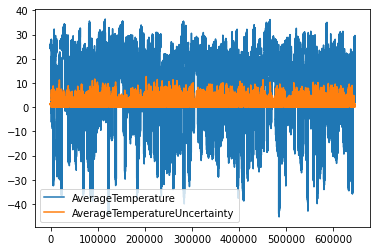

In [100]:
data_arima.plot()

In [101]:
data_arima

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil
...,...,...,...,...,...
645670,2013-05-01,21.634,0.578,Zhejiang,China
645671,2013-06-01,24.679,0.596,Zhejiang,China
645672,2013-07-01,29.272,1.340,Zhejiang,China
645673,2013-08-01,29.202,0.869,Zhejiang,China


In [139]:
#verificação de dada máxima, iremos considerar o mínimo como 1800
#print(data_arima['dt'].max())
# Convertendo a coluna "dt" para dados de data
data_arima['dt'] = pd.to_datetime(data_arima['dt'])
#observando análises anteriores foi possível notar que existe uma defasagem nos dados
#anteriores ao ano de 1800
data_arima.drop(data_arima[data_arima['dt']<='1800-01-01'].index, inplace=True)
data_arima.drop(data_arima[data_arima['dt']>='2013-09-01'].index, inplace=True)
data_arima.drop(data_arima[data_arima['State'] != 'Bahia'].index, inplace=True)
# Extraindo o ano da coluna "dt" para realizarmos uma análise por ano
data_arima["year"] = data_arima["dt"].dt.year

## Aqui começa a análise exploratória de dados para descobrir padrões e tendências, primeiro
## agrupando as temperaturas por ano e estado
dados_previsao = data_arima.groupby(["year","State"]).mean()

## Limpeza dos dados utilizando o método .dropna() para remover linhas com valores ausentes 
data_arima.dropna(inplace=True)

dados_previsao.drop('AverageTemperatureUncertainty', axis=1, inplace=True)

dados_previsao.head()

dados_previsao = dados_previsao.loc[(slice(None), "Bahia"), :]
dados_previsao = dados_previsao.loc[(slice(None), "State"), :]
dados_previsao = dados_previsao.reset_index(level=0)


dados_previsao.head()


,year,AverageTemperature
State,,
Bahia,1832,23.201917
Bahia,1833,23.958250
Bahia,1834,23.626250
Bahia,1835,22.881333
Bahia,1836,23.216417


In [131]:
dados_previsao.columns

Index(['year', 'AverageTemperature'], dtype='object')

In [136]:
dados_previsao.drop(columns=[''])

KeyError: "[''] not found in axis"